In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
import deepmatcher as dm
from utilities_functions.intermediate_layer_extraction import return_layer_input_output
import torch

torch.cuda.is_available()

True

In [5]:
hybrid_model = dm.MatchingModel(attr_summarizer='hybrid')
hybrid_model.load_state('models/hybrid2.pth')
hybrid_model.cuda()

MatchingModel(
  (attr_summarizers): ModuleMap(
    (Song_Name): Hybrid(
      (word_contextualizer): RNN(
        (rnn_groups): ModuleList(
          (0): GRU(300, 150, batch_first=True, bidirectional=True)
        )
        (dropouts): ModuleList(
          (0): Dropout(p=0)
        )
        (bypass_networks): ModuleList(
          (0): None
        )
        (input_dropout): NoMeta(
          (module): Dropout(p=0)
        )
      )
      (word_comparator): Attention(
        (alignment_networks): ModuleList(
          (0): AlignmentNetwork(
            (transform): Transform(
              (transforms): ModuleList(
                (0): Linear(in_features=300, out_features=300, bias=True)
                (1): Linear(in_features=300, out_features=300, bias=True)
              )
              (bypass_networks): ModuleList(
                (0): Bypass(
                  (highway_gate): Linear(in_features=300, out_features=300, bias=True)
                )
                (1): Bypass(


## Datasets creation

In [6]:
attributes = ['Song_Name','Artist_Name','Album_Name','Genre','Price','CopyRight','Time','Released']

In [7]:
neg_classifier_inputs,neg_classifier_outputs,neg_ids = return_layer_input_output('sample_data/itunes-amazon/'
                                                                         ,'test_negatives.csv',32,hybrid_model,
                                                                        hybrid_model.classifier)

In [8]:
neg_ids[0:5]

['325', '144', '222', '256', '472']

In [9]:
pos_classifier_inputs,pos_classifier_outputs,pos_ids = return_layer_input_output('sample_data/itunes-amazon/',
                                                                       'test_positives.csv',32,hybrid_model,
                                                                       hybrid_model.classifier)

In [10]:
negative_classifier_inputs = list(map(lambda x: x[0],neg_classifier_inputs))
positive_classifier_inputs = list(map(lambda x: x[0],pos_classifier_inputs))

## Utility methods

In [11]:
from utilities_functions.ri_calculator import find_smallest_variation_to_change

## Negative sample analysis

In [13]:
current_sample = 0
#each column of this matrix is related to a specific attribute
negatives_ri_matrix = []
for batch in test_negative_classifier_inputs:
    for sample_index in range(len(batch)):
        print('Processing sample number {}'.format(current_sample))
        current_sample_ris = list(map(lambda att: find_smallest_variation_to_change(model.classifier,
                                                                                    classifier_length=1200,
                                                                                    attribute_length=150,
                                                                                    input_matrix=batch,
                                                                                    vector_index=sample_index,
                                                                                    attributes=[attributes.index(att)]
                                                                                    ,class_to_reach=1),attributes))
        negatives_ri_matrix.append(current_sample_ris)
        current_sample+=1

Processing sample 0 with attribute Song_Name
Processing sample 0 with attribute Artist_Name
Processing sample 0 with attribute Album_Name
Processing sample 0 with attribute Genre
Processing sample 0 with attribute Price
Processing sample 0 with attribute CopyRight
Processing sample 0 with attribute Time
Processing sample 0 with attribute Released
Processing sample 1 with attribute Song_Name
Processing sample 1 with attribute Artist_Name
Processing sample 1 with attribute Album_Name
Processing sample 1 with attribute Genre
Processing sample 1 with attribute Price
Processing sample 1 with attribute CopyRight
Processing sample 1 with attribute Time
Processing sample 1 with attribute Released
Processing sample 2 with attribute Song_Name
Processing sample 2 with attribute Artist_Name
Processing sample 2 with attribute Album_Name
Processing sample 2 with attribute Genre
Processing sample 2 with attribute Price
Processing sample 2 with attribute CopyRight
Processing sample 2 with attribute Ti

Processing sample 23 with attribute Album_Name
Processing sample 23 with attribute Genre
Processing sample 23 with attribute Price
Processing sample 23 with attribute CopyRight
Processing sample 23 with attribute Time
Processing sample 23 with attribute Released
Processing sample 24 with attribute Song_Name
Processing sample 24 with attribute Artist_Name
Processing sample 24 with attribute Album_Name
Processing sample 24 with attribute Genre
Processing sample 24 with attribute Price
Processing sample 24 with attribute CopyRight
Processing sample 24 with attribute Time
Processing sample 24 with attribute Released
Processing sample 25 with attribute Song_Name
Processing sample 25 with attribute Artist_Name
Processing sample 25 with attribute Album_Name
Processing sample 25 with attribute Genre
Processing sample 25 with attribute Price
Processing sample 25 with attribute CopyRight
Processing sample 25 with attribute Time
Processing sample 25 with attribute Released
Processing sample 26 wi

Processing sample 47 with attribute Artist_Name
Processing sample 47 with attribute Album_Name
Processing sample 47 with attribute Genre
Processing sample 47 with attribute Price
Processing sample 47 with attribute CopyRight
Processing sample 47 with attribute Time
Processing sample 47 with attribute Released
Processing sample 48 with attribute Song_Name
Processing sample 48 with attribute Artist_Name
Processing sample 48 with attribute Album_Name
Processing sample 48 with attribute Genre
Processing sample 48 with attribute Price
Processing sample 48 with attribute CopyRight
Processing sample 48 with attribute Time
Processing sample 48 with attribute Released
Processing sample 49 with attribute Song_Name
Processing sample 49 with attribute Artist_Name
Processing sample 49 with attribute Album_Name
Processing sample 49 with attribute Genre
Processing sample 49 with attribute Price
Processing sample 49 with attribute CopyRight
Processing sample 49 with attribute Time
Processing sample 49

Processing sample 70 with attribute Album_Name
Processing sample 70 with attribute Genre
Processing sample 70 with attribute Price
Processing sample 70 with attribute CopyRight
Processing sample 70 with attribute Time
Processing sample 70 with attribute Released
Processing sample 71 with attribute Song_Name
Processing sample 71 with attribute Artist_Name
Processing sample 71 with attribute Album_Name
Processing sample 71 with attribute Genre
Processing sample 71 with attribute Price
Processing sample 71 with attribute CopyRight
Processing sample 71 with attribute Time
Processing sample 71 with attribute Released
Processing sample 72 with attribute Song_Name
Processing sample 72 with attribute Artist_Name
Processing sample 72 with attribute Album_Name
Processing sample 72 with attribute Genre
Processing sample 72 with attribute Price
Processing sample 72 with attribute CopyRight
Processing sample 72 with attribute Time
Processing sample 72 with attribute Released
Processing sample 73 wi

In [14]:
ri_norms_negative_samples = []
for ri_list in negatives_ri_matrix:
    ri_norms_negative_samples.append(list(map(lambda x:torch.norm(x).data[0],ri_list)))

In [15]:
import pandas as pd
variation_df = pd.DataFrame(data= ri_norms_negative_samples,columns=attributes)

In [16]:
ri_sums = variation_df.sum(numeric_only=True)

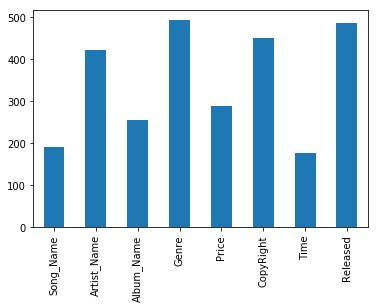

In [18]:
ri_sums.plot.bar()

In [19]:
variation_df.to_csv('experiments-results/exp3/testnegatives_ri.csv',index=False)

## Positive samples analisys

In [20]:
current_sample = 0
#each column of this matrix is related to a specific attribute
positives_ri_matrix = []
for batch in test_positive_classifier_inputs:
    for sample_index in range(len(batch)):
        print('Processing sample number {}'.format(current_sample))
        current_sample_ris = list(map(lambda att: find_smallest_variation_to_change(model.classifier,
                                                                                    classifier_length=1200,
                                                                                    attribute_length=150,
                                                                                    input_matrix=batch,
                                                                                    vector_index=sample_index,
                                                                                    attributes=[attributes.index(att)]
                                                                                    ,class_to_reach=0),attributes))
        positives_ri_matrix.append(current_sample_ris)
        current_sample+=1

Processing sample 0 with attribute Song_Name
Processing sample 0 with attribute Artist_Name
Processing sample 0 with attribute Album_Name
Processing sample 0 with attribute Genre
Processing sample 0 with attribute Price
Processing sample 0 with attribute CopyRight
Processing sample 0 with attribute Time
Processing sample 0 with attribute Released
Processing sample 1 with attribute Song_Name
Processing sample 1 with attribute Artist_Name
Processing sample 1 with attribute Album_Name
Processing sample 1 with attribute Genre
Processing sample 1 with attribute Price
Processing sample 1 with attribute CopyRight
Processing sample 1 with attribute Time
Processing sample 1 with attribute Released
Processing sample 2 with attribute Song_Name
Processing sample 2 with attribute Artist_Name
Processing sample 2 with attribute Album_Name
Processing sample 2 with attribute Genre
Processing sample 2 with attribute Price
Processing sample 2 with attribute CopyRight
Processing sample 2 with attribute Ti

Processing sample 23 with attribute Album_Name
Processing sample 23 with attribute Genre
Processing sample 23 with attribute Price
Processing sample 23 with attribute CopyRight
Processing sample 23 with attribute Time
Processing sample 23 with attribute Released
Processing sample 24 with attribute Song_Name
Processing sample 24 with attribute Artist_Name
Processing sample 24 with attribute Album_Name
Processing sample 24 with attribute Genre
Processing sample 24 with attribute Price
Processing sample 24 with attribute CopyRight
Processing sample 24 with attribute Time
Processing sample 24 with attribute Released
Processing sample 25 with attribute Song_Name
Processing sample 25 with attribute Artist_Name
Processing sample 25 with attribute Album_Name
Processing sample 25 with attribute Genre
Processing sample 25 with attribute Price
Processing sample 25 with attribute CopyRight
Processing sample 25 with attribute Time
Processing sample 25 with attribute Released
Processing sample 26 wi

In [21]:
ri_norms = []
for ri_list in positive_samples_ri_matrix:
    ri_norms.append(list(map(lambda x:torch.norm(x).data[0],ri_list)))

In [22]:
import pandas as pd
variation_df = pd.DataFrame(data= ri_norms,columns=attributes)
variation_df.head(10)

,Song_Name,Artist_Name,Album_Name,Genre,Price,CopyRight,Time,Released
0,5.591126,15.044979,8.888885,16.322388,7.571772,17.527578,4.673718,16.461742
1,6.870863,15.821705,9.012502,16.860628,7.832091,18.327745,4.922458,17.592426
2,5.341503,12.560771,6.858623,14.135549,7.049712,18.103035,5.242909,17.715355
3,2.564980,6.032977,3.427150,6.943195,3.463152,8.224591,2.542130,8.529947
4,0.962359,2.197567,1.275658,2.540286,1.288801,2.866425,0.937564,2.952036
5,8.989816,21.562540,10.841571,20.665524,10.330796,22.093853,8.451209,22.889296
6,3.827734,8.378418,4.975981,9.760432,4.264256,9.719053,3.154660,9.344310
7,6.847384,19.544884,9.933538,19.183775,9.573101,21.059700,6.517508,21.275204
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,4.148851,11.190358,5.337205,12.471942,4.530124,12.859291,3.382420,11.995663


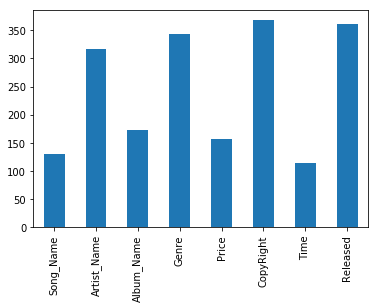

In [23]:
ri_sums = variation_df.sum(numeric_only=True)
ri_sums.plot.bar()

In [24]:
variation_df.to_csv('experiments-results/exp3/testpositives_ri.csv',index=False)

## Finding closer vectors

In [ ]:
from utilities_functions.distance_measures import nearest_neighbour,nearest_neighbour_onAttribute

In [29]:
#lista di tuple: vettore più vicino considerando tutti gli elementi e closer solo secondo un attributo
negatives_closer_vectors = []
i = 0
for batch in test_negative_classifier_inputs:
    for sample in batch:
        current_sample_closer_vectors = list(map(lambda att: nearest_neighbour_onAttribute
                                                 (sample+negatives_ri_matrix[i][attributes.index(att)]
                                                                ,positive_classifier_inputs,attributes.index(att),
                                                                attribute_length,'cosine'),attributes))
        negatives_closer_vectors.append(current_sample_closer_vectors)
        i += 1 

In [30]:
# per ogni attributo trovo il più vicino
positives_closer_vectors = []
i = 0
for batch in test_positive_classifier_inputs:
    for sample in batch:
        current_sample_closer_vectors = list(map(lambda att: nearest_neighbour_onAttribute
                                                 (sample+positives_ri_matrix[i][attributes.index(att)]
                                                                ,negative_classifier_inputs,attributes.index(att),
                                                                attribute_length,'cosine'),attributes))
        positives_closer_vectors.append(current_sample_closer_vectors)
        i += 1 

In [31]:
positives_closer_vectors_df = pd.DataFrame(data= positives_closer_vectors,columns =attributes)

In [33]:
negatives_closer_vectors_df = pd.DataFrame(data = negatives_closer_vectors, columns = attributes)

In [35]:
positives_closer_vectors_df = positives_closer_vectors_df.applymap(lambda c:neg_ids[c])

In [36]:
positives_closer_vectors_df.head(20)

,Song_Name,Artist_Name,Album_Name,Genre,Price,CopyRight,Time,Released
0,33,262,164,473,527,222,524,524
1,437,262,164,381,527,222,524,524
2,524,262,164,65,527,222,143,524
3,524,262,164,527,472,222,206,206
4,323,262,28,65,527,222,157,65
5,524,262,164,473,527,222,524,524
6,65,262,164,381,527,222,524,524
7,524,262,206,381,527,222,524,524
8,256,149,256,258,472,431,524,379
9,25,262,164,65,325,222,524,206


In [37]:
negatives_closer_vectors_df = negatives_closer_vectors_df.applymap(lambda c: pos_ids[c])

In [38]:
negatives_closer_vectors_df.head()

,Song_Name,Artist_Name,Album_Name,Genre,Price,CopyRight,Time,Released
0,433,186,292,386,304,324,440,47
1,87,389,280,292,304,283,7,47
2,87,56,373,386,304,183,370,47
3,407,283,212,47,183,45,389,252
4,87,186,407,292,304,283,324,304


In [ ]:
positives_closer_vectors_on_attribute_df = positives_closer_vectors_df.applymap(lambda c: c[1])

In [ ]:
positives_closer_vectors_on_attribute_df.head()

In [ ]:
negatives_closer_vectors_on_attribute_df = negatives_closer_vectors_df.applymap(lambda c : c[1])

In [ ]:
positives_closer_vectors_df['Pos_sample_ID']= ordered_id_positives
positives_closer_vectors_on_attribute_df['Pos_sample_ID'] = ordered_id_positives

In [ ]:
positives_closer_vectors_df.to_csv('positives_closer_vectors.csv',sep=';',index=False)

In [ ]:
positives_closer_vectors_on_attribute_df.to_csv('positives_closer_vectors_on_attribute.csv',sep=';',index=False)

In [ ]:
negatives_closer_vectors_df['Neg_sample_ID'] = ordered_id_negatives
negatives_closer_vectors_on_attribute_df['Neg_sample_ID'] = ordered_id_negatives

In [ ]:
negatives_closer_vectors_df.to_csv('negatives_closer_vectors.csv',sep=';',index=False)
negatives_closer_vectors_on_attribute_df.to_csv('negatives_closer_vector_on_attribute.csv',sep=';',index=False)

### Some tests

In [ ]:
it,variation = find_smallest_variation_to_change(hybrid_model.classifier,positive_classifier_inputs[0],20,6,0)

In [ ]:
positive_classifier_inputs[0][20].data = positive_classifier_inputs[0][20].data.copy_(positive_classifier_inputs[0][20].data+
                                                                                     variation.data)

In [ ]:
hybrid_model.classifier.forward(positive_classifier_inputs[0])[20]

In [ ]:
grads_list = []
h = positive_classifier_inputs[0].register_hook(lambda g: grads_list.append(g))

In [ ]:
out = hybrid_model.classifier.forward(positive_classifier_inputs[0])
prob = get_probabilites(out[20])

In [ ]:
from torch.autograd import Variable
true_labels = Variable (torch.cuda.FloatTensor([0,1]))